# **케라스 - 고양이와 개의 전이 학습**

---

이 수업에서는 데이터 생성기를 설정하여 자체 데이터 세트를 로드하고 Keras를 사용하여 분류기를 훈련하는 방법을 배운다.
1. 신경망의 훈련 가능한 계층 이해
2. 데이터 설정 중
3. 전이 학습을 위한 모델 구축
4. 미세 조정 수행

In [ ]:
# Import of libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras

## **훈련 가능 계층**
Trainable Layers
레이어 및 모델에는 **3**의 가중치 속성이 있습니다:

- weights는 레이어의 모든 가중치 변수 목록이다.
- 'trainable_weights'는 업데이트 대상 목록입니다(구배를 통해)
하강) 훈련 중 손실을 최소화합니다.
- 'non_trainable_weights'는 훈련 대상이 아닌 것들의 목록이다.
일반적으로 전달 패스 중에 모델에 의해 업데이트됩니다.

**예: '밀도' 레이어에는 2개의 훈련 가능한 가중치(커널 및 바이어스)가 있습니다**[링크 텍스트](https://)

In [ ]:
layer = keras.layers.Dense(4)

# Create the weights using layer.build
layer.build((None, 2))

print(f'Number of weights: {len(layer.weights)}')
print(f'Number of trainable_weights: {len(layer.trainable_weights)}')
print(f'Number of non_trainable_weights: {len(layer.non_trainable_weights)}')

Number of weights: 2
Number of trainable_weights: 2
Number of non_trainable_weights: 0


All layers are trainable with the exception of **BatchNormalization**. It uses non-trainable weights to keep track of the mean and variance of its inputs during training.

**Layers & models** also feature a boolean attribute `trainable`.

Its value can be changed by setting `layer.trainable` to `False` moves all the layer's weights from trainable to non-trainable.  

This is called **"freezing"** the layer: the state of a frozen layer won't
be updated during training (either when training with `fit()` or when training with
 any custom loop that relies on `trainable_weights` to apply gradient updates).

### **Example: setting `trainable` to `False`**

In [ ]:
# Make a model with 2 layers
layer1 = keras.layers.Dense(3, activation="relu")
layer2 = keras.layers.Dense(3, activation="sigmoid")
model = keras.Sequential([keras.Input(shape=(3,)), layer1, layer2])

# Freeze the first layer
layer1.trainable = False

# Keep a copy of the weights of layer1 for later reference
initial_layer1_weights_values = layer1.get_weights()

# Train the model
model.compile(optimizer="adam", loss="mse")
model.fit(np.random.random((2, 3)), np.random.random((2, 3)))

1/1 [==============================] - 1s 521ms/step - loss: 0.0446


In [ ]:
# Check that the weights of layer1 have not changed during training
final_layer1_weights_values = layer1.get_weights()

if initial_layer1_weights_values[0].all() == final_layer1_weights_values[0].all():
  print('Weights unchanged')

if initial_layer1_weights_values[1].all() == final_layer1_weights_values[1].all():
  print('Weights unchanged')

Weights unchanged
Weights unchanged


**Note**: **`.trianable` is Recursive**, meaning that on a model or on any layer that has sublayers, all children layers become non-trainable as well.

## **Implementing Transfer Learning**

![](https://github.com/rajeevratan84/ModernComputerVision/blob/main/Screenshot%202021-05-11%20at%2011.49.01%20pm.png?raw=true)

## **Transfer-learning workflow**

1. We instantiate a **base model and load pre-trained weighs** into it.
2. **Freeze** all layers in the base model by setting `trainable = False`.
3. Create a **new model on top** of the output of one (or several) layers from the base
 model.
4. Train your new model on your new dataset.

## ** 전이 학습 구현**

![](https://github.com/rajeevratan84/ModernComputerVision/blob/main/Screenshot%202021-05-11%20at%2011.49.01%20pm.png?raw=true)

## **이전-학습 워크플로우**

1. 우리는 **기본 모델을 인스턴스화하고 사전 훈련된 무게**를 그 모델에 로드한다.
2. **'trainable = False'를 설정하여 기본 모델의 모든 레이어를 고정합니다.
3. 기본에서 하나(또는 여러 개) 레이어의 출력 상단**에 **새 모델 생성
모형을 만들다.
4. 새로운 데이터 세트에서 새로운 모델을 교육합니다.

### **Step 1. Load a base model with pre-trained weights (ImageNet)**

In [ ]:
import tensorflow_datasets as tfds

# 진행 표시줄 비활성화
tfds.disable_progress_bar()

# 데이터셋 로드 및 분할
train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # 10%를 검증 데이터로, 10%를 테스트 데이터로 예약
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # 레이블 포함
)

# 각 데이터셋의 샘플 수 출력
print(f'Number of training samples: {tf.data.experimental.cardinality(train_ds)}')
print(f'Number of validation samples: {tf.data.experimental.cardinality(validation_ds)}')
print(f'Number of test samples: {tf.data.experimental.cardinality(test_ds)}')


Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1DQMSY/cats_vs_dogs-train.tfrecord
Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


These are the first 9 images in the training dataset -- as you can see, they're all
 different sizes.

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(20)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title('Cat' if int(label) == 0 else 'Dog')
    plt.axis("off")

NameError: name 'train_ds' is not defined

<Figure size 1000x1000 with 0 Axes>

## **Standardize Our Data**

- Standardize to a fixed image size. We pick 150x150.
- Normalize pixel values between -1 and 1. We'll do this using a `Normalization` layer as
 part of the model itself.

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

We'll batch the data and use caching & prefetching to optimize loading speed.

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

### **Introduce some random data augmentation**

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 데이터 증강을 위한 케라스 Sequential 모델을 생성합니다.
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),  # 수평으로 이미지를 랜덤 뒤집기
        layers.experimental.preprocessing.RandomRotation(0.1),      # 이미지를 0.1 라디안만큼 랜덤 회전
    ]
)


#### **Visualize our Data Augmentations**

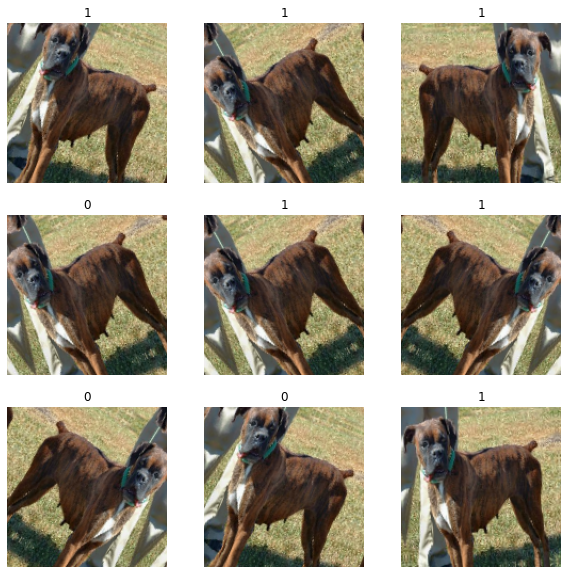

In [ ]:
import numpy as np

# 훈련 데이터셋에서 첫 번째 배치를 가져와서 데이터 증강 결과를 시각화합니다.
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # 첫 번째 이미지를 증강하고 결과를 시각화합니다.
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        # 증강된 이미지를 플롯에 표시합니다.
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        # 레이블을 제목으로 설정합니다.
        plt.title(int(labels[i]))
        # 축을 숨깁니다.
        plt.axis("off")


## **3. Building our model**

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

- We'll be using the **Xception Model** as our base.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

# 사전 훈련된 Xception 모델 로드 (ImageNet 가중치 사용)
base_model = keras.applications.Xception(
    weights="imagenet",  # ImageNet에서 사전 훈련된 가중치 로드
    input_shape=(150, 150, 3),
    include_top=False,   # 상단의 ImageNet 분류기를 포함하지 않음
)

# 기본 모델의 가중치를 동결
base_model.trainable = False

# 새로운 모델 생성
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # 랜덤 데이터 증강 적용

# 사전 훈련된 Xception 가중치가 입력을 (0, 255)에서 (-1., +1.) 범위로 스케일링 해야 함
# rescaling 레이어는 `(inputs * scale) + offset`를 출력함
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# 기본 모델에는 배치 정규화 레이어가 포함되어 있음
# 미세 조정을 위해 기본 모델의 가중치를 동결 해제할 때 추론 모드로 유지하기 위해
# 여기서 기본 모델이 추론 모드로 실행되도록 설정
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # 드롭아웃을 통해 정규화
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()


83697664/83683744 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

## **Now let's Train our Top Layer**

Note from the above summary that we only have 2,049 trainable paramaters.

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
291/291 [==============================] - 689s 2s/step - loss: 0.1793 - binary_accuracy: 0.9192 - val_loss: 0.0832 - val_binary_accuracy: 0.9678
Epoch 2/20
291/291 [==============================] - 660s 2s/step - loss: 0.1163 - binary_accuracy: 0.9515 - val_loss: 0.0743 - val_binary_accuracy: 0.9716
Epoch 3/20
291/291 [==============================] - 694s 2s/step - loss: 0.1073 - binary_accuracy: 0.9557 - val_loss: 0.0725 - val_binary_accuracy: 0.9721
Epoch 4/20
291/291 [==============================] - 703s 2s/step - loss: 0.1085 - binary_accuracy: 0.9556 - val_loss: 0.0731 - val_binary_accuracy: 0.9721
Epoch 5/20
291/291 [==============================] - 697s 2s/step - loss: 0.1018 - binary_accuracy: 0.9589 - val_loss: 0.0737 - val_binary_accuracy: 0.9703
Epoch 6/20
 26/291 [=>............................] - ETA: 8:32 - loss: 0.0861 - binary_accuracy: 0.9627

## **4. Fine Tuning**

We **unfreeze** the base model and train the entire model end-to-end with a **low** learning rate.

**Notes** although the base model becomes trainable, it is still running in inference mode since we passed `training=False` when calling it when we built the model.

This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
# 기본 모델의 동결을 해제
base_model.trainable = True
model.summary()

# 모델 컴파일
model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # 낮은 학습률
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

# 훈련 설정
epochs = 10  # 총 10 에포크 동안 훈련

# 모델 훈련
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 150, 150, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                           